# Barlow Twins

In this session we are going to implement Barlow Twins paper (https://arxiv.org/abs/2103.03230).

It follows the same batch construction as SimCLR. The loss is:
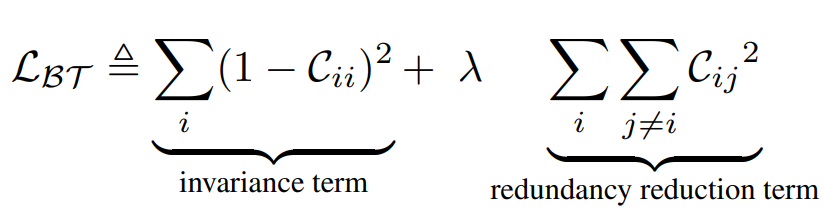



BT si basa sulla matrice di cross-correlazione. 

Bisogna distinguere due casi: una volta ottenuta questa matrice di cross-corellazione si agisce in un modo sugli elementi della diagonale principale (Cii) (si farà (1 - Cii)^2), e si agirà in un'altra maniera negli elementi off-diagonal. 

Come si costruisce la matrice: si va a fare il prodotto tra elemento per elemento diviso i valori degli elementi al quadrato, in pratica si fa una norma. 

Quindi dovremmo andare a normalizzare le feature che abbiamo (za e zb) e poi facciamo il prodotto element-wise.

Andiamo a implementare BT, si può partire dall'implementazione di SimCLR perchè quello che va a fare BT è agire sulla matrice di similitudine.

In [ ]:
import os
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision.io import read_image

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, data, targets = None, transform=None, target_transform=None): # valori di default
        self.imgs = data
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        if isinstance(img, str):
          image = read_image(img)
        else:
          image = Image.fromarray(img.astype('uint8'), 'RGB')
        if self.transform: # arriva qui con una PIL image
            image1 = self.transform(image) # fa due trasformazioni
            image2 = self.transform(image)
        else:
            image1 = image
            image2 = image
        return image1, image2


class Identity(torch.nn.Module):
  def forward(self, x):
    return x


class SiameseNet(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.encoder1 = backbone
        self.encoder1.fc = Identity()

        self.encoder2 = backbone
        self.encoder2.fc = Identity()


    def forward(self, x1, x2, return_dict = True):
        x1 = self.encoder1(x1)
        x2 = self.encoder2(x2)
        return torch.cat((x1, x2), dim = 0)

Il projector di BT è fatto così: alle features (che sarebbero l'uscita della ResNet) ci si applica il projector definito sotto e poi si fa BatchNorm, per ottenere x1 e x2. Prese x1 e x2,vogliamo andare a fare la matrice di cross-covarianza. Qui c'è la moltiplicazione fra le versioni augmented e le altre versioni augmented.

Poi si prendono tutti gli elementi sulla diagonale principale e di questi si fanno (1 - elementi_diagonale)^2 e poi si somma lambda, poi si prendono tutti gli elementi off diagonal ed elevarli al quadrato.

In [ ]:
def off_diagonal(x):
    # return a flattened view of the off-diagonal elements of a square matrix
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()


class BarlowTwinsLoss(nn.Module): # fa la projection di feature1 e feature2 e poi costruisce la matrice di cross-correlazione
    def __init__(self, lambd):
        super().__init__()
        self.lambd = lambd

        # barlow twin projector
        sizes = [512, 2048] # [512, 2048, 2048, 1024]
        layers = []
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=False))
            layers.append(nn.BatchNorm1d(sizes[i + 1]))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(sizes[-2], sizes[-1], bias=False))
        self.projector = nn.Sequential(*layers)

        # normalization layer for the representations z1 and z2
        self.bn = nn.BatchNorm1d(sizes[-1], affine=False)

    def forward(self, features1, features2): # va bene anche mettere features, non metterle splittate
        # batch_size = features.shape[0]
        x1 = self.bn(self.projector(features1))
        x2 = self.bn(self.projector(features2))

        # cross-correlation matrix
        cross_corr_matrix = x1.T @ x2
        cross_corr_matrix.div_(x1.size(0))
        # in place # cross_corr_matrix = cross_corr_matrix.div(features1.shape[0])

        invariance = torch.diagonal(cross_corr_matrix).add_(-1).pow_(2).sum() # estraggo i cii
        redundancy_reduction = off_diagonal(cross_corr_matrix).pow_(2).sum()

        loss = invariance + self.lambd * redundancy_reduction
        return loss

In [ ]:
data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True) # dataset

color_jitter = transforms.ColorJitter(0.8, 0.8, 0.8, 0.2) # si distorce il colore con una certa probabilità tutti i canali


transform = transforms.Compose([transforms.RandomResizedCrop(size=32),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomApply([color_jitter], p=0.8),
                                  transforms.RandomGrayscale(p=0.2),
                                  transforms.GaussianBlur(kernel_size=int(0.1 * 32)),
                                  transforms.ToTensor()])

trainset = CustomImageDataset(data.data, transform = transform)
dataloader = DataLoader(trainset, batch_size=64, shuffle=True)



model = SiameseNet(models.resnet18())
optimizer = optim.Adam(model.parameters())
criterion = BarlowTwinsLoss(0.005)

for idx, data in enumerate(dataloader):
    view1, view2 = data

    optimizer.zero_grad()
    features = model(view1, view2)
    loss = criterion(features[:64], features[:64])
    loss.backward()
    optimizer.step()

    print(f"batch {idx} loss {loss.item()}")
    print()

    if idx == 3:
        break

Files already downloaded and verified
batch 0 loss 821.279296875

batch 1 loss 596.9554443359375

batch 2 loss 547.4212646484375

batch 3 loss 537.4692993164062

